In [97]:
from brian2 import *
from scipy import signal
import numpy as np
%matplotlib notebook

In [98]:
def back_current(mean, std, enhancement, runtime, dt=0.001, tau=15, N=10, order=1):
    sampling_rate = 1/dt
    nyquist = sampling_rate/2
    cutoff = 1/tau
    normalized_cutoff = cutoff/nyquist
    
    
    back_noise = np.random.normal(enhancement*mean, std, (int(runtime/dt), N))
    b, a = signal.butter(order, normalized_cutoff, btype='low', analog=False)
    back_noise_filt = signal.lfilter(b, a, back_noise[:,0])

    if(N > 1):
        for j in range(1, N):
            back_noise_filt = np.vstack((back_noise_filt, signal.lfilter(b, a, back_noise[:,j])))
    
    return back_noise_filt.T

def input_stimulus(mean, std, runtime, dt, tau, order):
    sampling_rate = 1/dt
    nyquist = sampling_rate/2
    cutoff = 1/tau
    normalized_cutoff = cutoff/nyquist

    input_noise= (np.random.normal(mean, std, int(runtime/dt)))
    
    b, a = signal.butter(order, normalized_cutoff, btype='low', analog=False)
    
    input_noise_filt = signal.lfilter(b, a, input_noise)
    
    for i in range(0, len(input_noise_filt)): 
        if(input_noise_filt[i] < 0):
            input_noise_filt[i] = 0
            
    return input_noise_filt

def psth(spike, lim, tbin):
    ## remove unwanted t from spike_t, spike_i index only within defined limit
    spike_i = []
    spike_t = []
    for j in range(0, size(spike.i)):
        if(spike.i[j] > lim[0] and spike.i[j] < lim[1]):
            spike_t.append(spike.t[j])
            spike_i.append(spike.i[j])
            
    t = 0
    count = 0
    freq = []
    tvec = []
    
    for k in range(0, size(spike_t)):
        while(spike_t[k] > t):
            freq.append(count/(20*tbin))
            count = 0;
            tvec.append(t)
            t += tbin;
            if(spike_t[k] <= t):
                count +=1;
        count +=1;
    
    return freq, tvec

def visualise_connectivity(S):
    Ns = len(S.source)
    Nt = len(S.target)
    figure(figsize=(10, 4))
    subplot(121)
    plot(zeros(Ns), arange(Ns), 'ok', ms=10)
    plot(ones(Nt), arange(Nt), 'ok', ms=10)
    for i, j in zip(S.i, S.j):
        plot([0, 1], [i, j], '-k')
    xticks([0, 1], ['Source', 'Target'])
    ylabel('Neuron index')
    xlim(-0.1, 1.1)
    ylim(-1, max(Ns, Nt))
    subplot(122)
    plot(S.i, S.j, 'ok')
    xlim(-1, Ns)
    ylim(-1, Nt)
    xlabel('Source neuron index')
    ylabel('Target neuron index')



In [99]:
##### SIMULATION #####

start_scope()

N = 20
N_tot = 200
dt = 0.1*ms
back_curr = back_current(55e-12, 70e-12, 1.525, 1, .0001, .002, 20, 1)
back_curr2 = back_current(55e-12, 70e-12, 1.49, 1, .0001, .002, N_tot-20, 1)
input_stim = input_stimulus(0, 2000e-12, 1, .0001, .5, 1)
I_back = TimedArray(back_curr, dt = dt)
I_back2 = TimedArray(back_curr2, dt = dt)
I_input = TimedArray(input_stim, dt = dt)
Vreversal = 0
v0 = -60e-3
R = 100e6
tau = 5*ms
taug = 5*ms
C = tau/R

### Layer 1 Neuron Equation
# No synaptic current input
eqs_1 = '''
dv/dt = (-v + I_input(t)*R + I_back(t, i)*R + v0 )/tau : 1 (unless refractory)
'''

### Layers 2+ Neuron Equations
# Conductance based synaptic current input
eqs_2 = '''
I_conductance = -g*(v-Vreversal) : 1
dv/dt = (-v/(R*C) + I_back2(t, i)/(C) + v0/(R*C) - g*(v-Vreversal)/C) : 1 (unless refractory)
dg/dt = -g/taug : 1
'''

M = NeuronGroup(N, eqs_1, threshold='v>-50e-3', reset='v = -60e-3', refractory=1*ms, method='euler', dt = 0.1*ms)
M.v = -60e-3
M1 = NeuronGroup(N*9, eqs_2, threshold='v>-50e-3', reset='v = -60e-3',refractory=1*ms,  method='euler', dt = 0.1*ms)
M1.v = -60e-3
M1.g = 0

### Layer 1 - Layer 2 Synapses
s = Synapses(M, M1, on_pre='g_post += 9e-11') 
s.connect(j = 'k for k in range(0, 20)')

### Layer 2 - Layer 3 Synapses
s2 = Synapses(M1, M1, on_pre='g_post += 9e-11')
for y in range(0, 20):
    s2.connect(i = y, j = range(20, 40))

### Layer 3 - Layer 4 Synapses
for y in range(20, 40):
    s2.connect(i = y, j = range(40, 60))

### Layer 4 - Layer 5 Synapses
for y in range(40, 60):
    s2.connect(i = y, j = range(60, 80))
    
### Layer 5 - Layer 6 Synapses
for y in range(60, 80):
    s2.connect(i = y, j = range(80, 100))
    
### Layer 6 - Layer 7 Synapses
for y in range(80, 100):
    s2.connect(i = y, j = range(100, 120))
    
### Layer 7 - Layer 8 Synapses
for y in range(100, 120):
    s2.connect(i = y, j = range(120, 140))
    
### Layer 8 - Layer 9 Synapses
for y in range(120, 140):
    s2.connect(i = y, j = range(140, 160))
    
### Layer 9 - Layer 10 Synapses
for y in range(140, 160):
    s2.connect(i = y, j = range(160, 180))
    

### State Monitors
Mv = StateMonitor(M, 'v', record=True)
Mspk = SpikeMonitor(M)
M1v = StateMonitor(M1, 'v', record=True)
Mspk1 = SpikeMonitor(M1)
M1_I_conductance = StateMonitor(M1, 'I_conductance', record = True)
M1_g = StateMonitor(M1, 'g', record = True)

run(1000*ms)


<IPython.core.display.Javascript object>


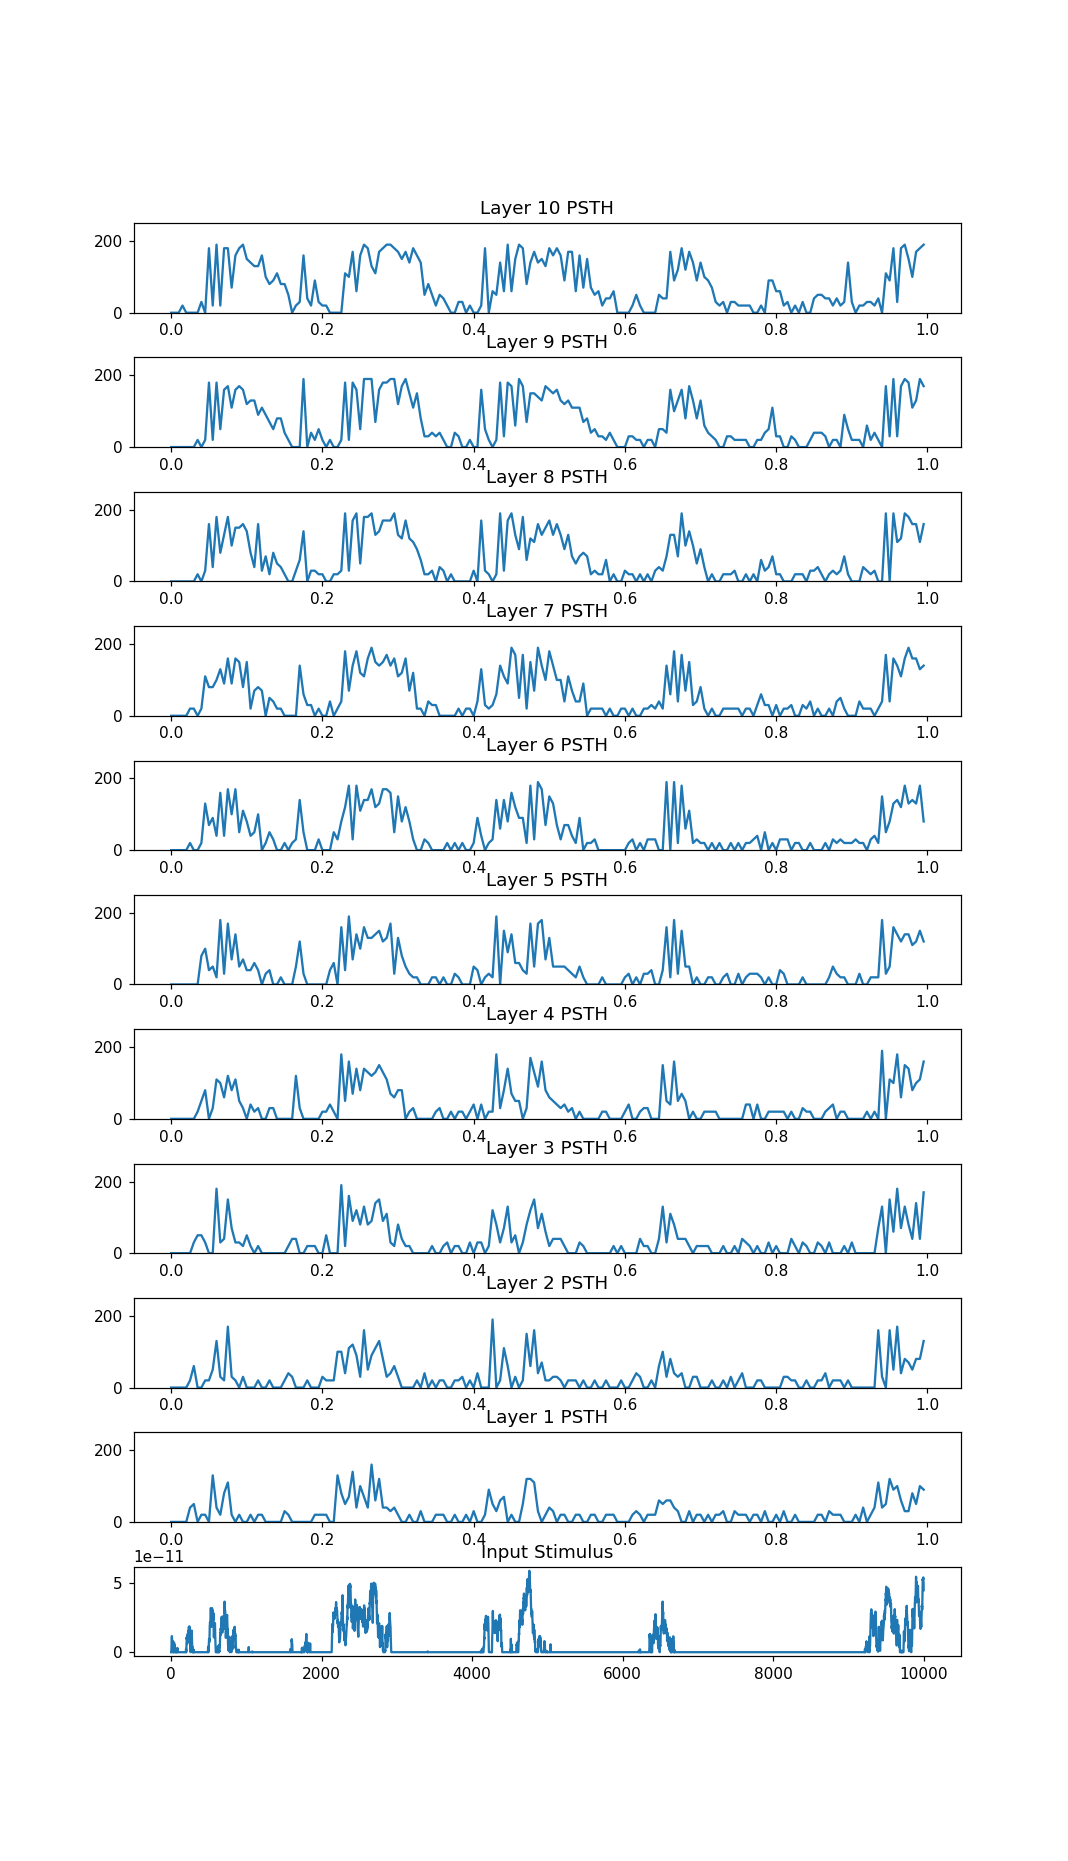

In [100]:
freq0, tvec0 = psth(Mspk, [0, 30], 5*ms)
freq1, tvec1 = psth(Mspk1, [0, 19], 5*ms)
freq2, tvec2 = psth(Mspk1, [20, 39], 5*ms)
freq3, tvec3 = psth(Mspk1, [40, 59], 5*ms)
freq4, tvec4 = psth(Mspk1, [60, 79], 5*ms)
freq5, tvec5 = psth(Mspk1, [80, 99], 5*ms)
freq6, tvec6 = psth(Mspk1, [100, 119], 5*ms)
freq7, tvec7 = psth(Mspk1, [120, 139], 5*ms)
freq8, tvec8 = psth(Mspk1, [140, 159], 5*ms)
freq9, tvec9 = psth(Mspk1, [160, 179], 5*ms)


fig2 = figure(24)

subplot(11,1,1)
plot(tvec9, freq9)
title('Layer 10 PSTH')
ylim(0, 250)

subplot(11,1,2)
plot(tvec8, freq8)
title('Layer 9 PSTH')
ylim(0, 250)

subplot(11,1,3)
plot(tvec7, freq7)
title('Layer 8 PSTH')
ylim(0, 250)

subplot(11,1,4)
plot(tvec6, freq6)
title('Layer 7 PSTH')
ylim(0, 250)

subplot(11,1,5)
plot(tvec5, freq5)
title('Layer 6 PSTH')
ylim(0, 250)

subplot(11,1,6)
plot(tvec4, freq4)
title('Layer 5 PSTH')
ylim(0, 250)

subplot(11,1,7)
plot(tvec3, freq3)
title('Layer 4 PSTH')
ylim(0, 250)

subplot(11,1,8)
plot(tvec2, freq2)
title('Layer 3 PSTH')
ylim(0, 250)

subplot(11,1,9)
plot(tvec1, freq1)
title('Layer 2 PSTH')
ylim(0, 250)

subplot(11,1,10)
plot(tvec0, freq0)
title('Layer 1 PSTH')
ylim(0, 250)

subplot(11,1,11)
plot(input_stim)
title('Input Stimulus')
fig2.subplots_adjust(hspace=.5)


<IPython.core.display.Javascript object>


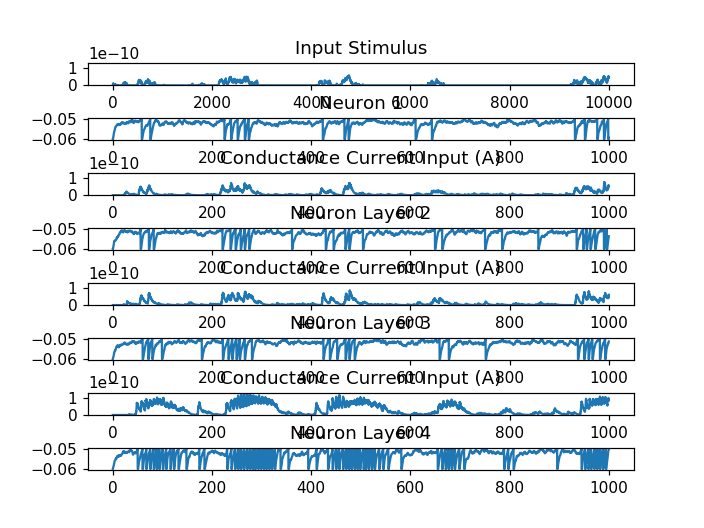

<IPython.core.display.Javascript object>


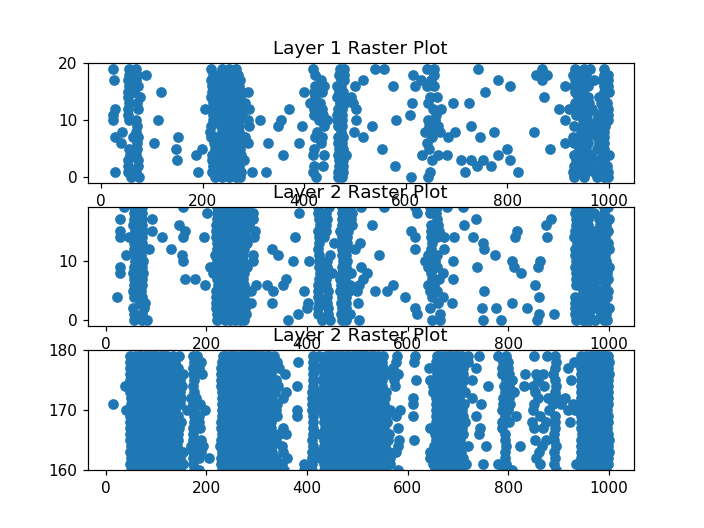

(160, 180)

In [101]:
freq0, tvec0 = psth(Mspk, [0, 30], 5*ms)
freq1, tvec1 = psth(Mspk1, [0, 19], 5*ms)
freq4, tvec4 = psth(Mspk1, [60, 79], 5*ms)
freq9, tvec9 = psth(Mspk1, [160, 179], 5*ms)


### FIGURE 1 ###
fig1 = figure(20)

subplot(8,1,1)
plot(input_stim)
title('Input Stimulus')
ylim(0, 1.3e-10)

subplot(8,1,2)
plot(Mv.t/ms, Mv.v[0], label='Neuron 0')
title('Neuron 1')
#xlim(280,360)

# subplot(6,1,3)
# title('Conductance Current Input (I)')
# plot(M1g.t/ms, M1g.I_conductance[0, :])
# #xlim(280,360)
# ylim(0,1.3e-10)

subplot(8,1,3)
title('Conductance Current Input (A)')
plot(M1_I_conductance.t/ms, M1_I_conductance.I_conductance[0, :])
#xlim(280,360)
ylim(0,1.3e-10)

subplot(8,1,4)
title('Neuron Layer 2')
plot(M1v.t/ms, M1v.v[0], label='Neuron 0')
#xlim(280,360)

subplot(8,1,5)
title('Conductance Current Input (A)')
plot(M1_I_conductance.t/ms, M1_I_conductance.I_conductance[22, :])
#xlim(280,360)
ylim(0,1.3e-10)

subplot(8,1,6)
title('Neuron Layer 3')
plot(M1v.t/ms, M1v.v[22], label='Neuron 0')
#xlim(280,360)

subplot(8,1,7)
title('Conductance Current Input (A)')
plot(M1_I_conductance.t/ms, M1_I_conductance.I_conductance[160, :])
#xlim(280,360)
ylim(0,1.3e-10)

subplot(8,1,8)
title('Neuron Layer 4')
plot(M1v.t/ms, M1v.v[160], label='Neuron 0')
#xlim(280,360)

fig1.subplots_adjust(hspace=1.5)

figure(22)
subplot(3,1,1)
title('Layer 1 Raster Plot')
scatter(Mspk.t/ms, Mspk.i)
#ylim(-1, 9)

subplot(3,1,2)
title('Layer 2 Raster Plot')
scatter(Mspk1.t/ms, Mspk1.i)
ylim(-1, 19)

subplot(3,1,3)
title('Layer 2 Raster Plot')
scatter(Mspk1.t/ms, Mspk1.i)
ylim(160,180 )
